# дз 3 по нейросетям

In [5]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import Counter

Сейчас достанем нужные даные

In [6]:
data = pd.read_csv('Fake.csv', delimiter=',')

In [7]:
data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


Посмотрим на все и сделаем предобработку

In [8]:
s = []
for i in data['subject']:
  if i not in s:
    s.append(i)
print(s)

['News', 'politics', 'Government News', 'left-news', 'US_News', 'Middle-east']


In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
t = []
for i in data['text']:
  if type(i) not in t:
    t.append(type(i))
t

[str]

In [11]:
titles = data['title'].tolist()

In [12]:
texts = data['text'].tolist()

In [13]:
ttexts = []
for text in texts:
  ttexts.append(word_tokenize(text))

In [14]:
max=0
for i in ttexts:
  if len(i) > max:
    max=len(i)
max

9939

In [15]:
ts = []
for i in ttexts:
  a = []
  for j in i:
    a.append(j.lower())
  ts.append(a)



In [16]:
texts = [i[:1000] for i in ts]

Создадим новый датафрейм из того что нужно

In [17]:
df = pd.DataFrame({'subj': data['subject'].tolist(), 'texts': pd.Series(texts)})

In [18]:
df

,subj,texts
0,News,"[donald, trump, just, couldn, t, wish, all, am..."
1,News,"[house, intelligence, committee, chairman, dev..."
2,News,"[on, friday, ,, it, was, revealed, that, forme..."
3,News,"[on, christmas, day, ,, donald, trump, announc..."
4,News,"[pope, francis, used, his, annual, christmas, ..."
...,...,...
23476,Middle-east,"[21st, century, wire, says, as, 21wire, report..."
23477,Middle-east,"[21st, century, wire, says, it, s, a, familiar..."
23478,Middle-east,"[patrick, henningsen, 21st, century, wireremem..."
23479,Middle-east,"[21st, century, wire, says, al, jazeera, ameri..."


In [19]:
cat_mapper = {cat: n for n, cat in enumerate(df.subj.unique())}

In [20]:
df.subj= df.subj.map(cat_mapper)

Подготовим словари для датасета

In [21]:
vocab = Counter()
for text in texts:
    for token in text:
        vocab[token] += 1

In [22]:
tokens = set()
for key, value in vocab.items():
    if value > 10:
        tokens.add(key)

In [23]:
word2id = {'PAD':0}

for word in tokens:
    word2id[word] = len(word2id)

In [24]:
id2word = {i:word for word, i in word2id.items()}

In [25]:
!pip install -q torchmetrics

     |████████████████████████████████| 332 kB 5.3 MB/s 


In [26]:
!pip install -q ipdb

     |████████████████████████████████| 791 kB 5.2 MB/s 
     |████████████████████████████████| 374 kB 40.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.30.1 which is incompatible.


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

In [28]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=21, shuffle=True)

In [29]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [30]:
max_len = 1000

Сделаем датасет

In [31]:
class NewsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE, max_len=max_len):
        self.max_len = max_len
        self.dataset = dataset['texts'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['subj'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index]
        ids = torch.LongTensor([self.word2id[word] if word in self.word2id else self.word2id['PAD'] for word in words][:self.max_len])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
        ids, y = list(zip(*batch))
        if max([len(i) for i in ids]) < self.max_len:
            padded_ids = pad_sequence(ids, batch_first=True)

        else:
            padded_ids = torch.vstack([F.pad(torch.LongTensor(text_ids), 
                                            (0, self.max_len-len(text_ids))) for text_ids in ids])
       
        padded_ids = padded_ids.to(self.device)
        y = torch.squeeze(torch.Tensor(y).long()).to(self.device)
        return padded_ids, y

In [32]:
train_dataset = NewsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset) 
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn,sampler=train_sampler, batch_size=128)

In [34]:
val_dataset = NewsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=128)

Скачаем эмбеддинги

In [2]:
! wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2021-12-29 14:58:30--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.166.160
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.166.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  73.6MB/s    in 24s     

2021-12-29 14:58:54 (66.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [35]:
from gensim import models

w = models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin.gz', binary=True)

weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w[word]    
    except KeyError:
        count += 1
        weights[i] = np.random.normal(0,0.1,300)

Напишем модель

In [36]:
class CLSTM(nn.Module):
    
    def __init__(self, weights, lstm_size, out_conv):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(weights), freeze=False)
        self.bigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=out_conv, kernel_size=3)
        self.relu = nn.ReLU()
        
        self.LSTM = nn.LSTM(input_size=out_conv, hidden_size=lstm_size,
                          num_layers=1, batch_first=True)
        
        
        self.hidden = nn.Linear(in_features=lstm_size, out_features=6)
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        #batch_size x n_channels x seq_length
        feature_map_bigrams = self.relu(self.bigrams(self.dropout(embedded)))
        #batch_size x n_channels x seq_length
        
        x, _ = self.LSTM(feature_map_bigrams.transpose(1, 2))
        h_s, c_s = _[0], _[1]

        logits = self.dropout(self.hidden(h_s.transpose(0, 1).squeeze()))
        
        return logits

In [37]:
def train(model, iterator, optimizer, criterion):
    print(next(model.parameters()))

    epoch_loss = 0 
    model.train()  
    for i, (texts, ys) in enumerate(iterator): 
        optimizer.zero_grad() 
        preds = model(texts)  
        loss = criterion(preds, ys) 
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}') 
    
    print(next(model.parameters()))

    return model, epoch_loss / len(iterator) 

In [38]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds, ys, average='micro', num_classes=6)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i+1)}, Val f1: {epoch_metric/(i+1)}')

    return model, epoch_metric / len(iterator), epoch_loss / len(iterator) 

In [39]:
def learning(n_epochs, model, optimizer, criterion):
    for i in range(n_epochs):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        model, epoch_loss = train(model, train_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        model, f1_on_train, _ = evaluate(model, train_iterator, criterion)
        f1s.append(f1_on_train.cpu())
        print('\nEvaluating on test...')
        model, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test.cpu())

In [40]:
import traceback
import sys

In [42]:
del max

Запустим!

In [43]:
try:
    model = CLSTM(weights, lstm_size=150, out_conv=150)
    optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)
    criterion = nn.CrossEntropyLoss() # 
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    learning(5, model, optimizer, criterion)

except Exception or KeyboardInterrupt:
    traceback.print_exc()
    del model, optimizer, criterion
    torch.cuda.empty_cache()


starting Epoch 0
Training...
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0352,  0.3535,  0.0664,  ..., -0.2197,  0.0938, -0.0181],
        [-0.1226, -0.1777,  0.2354,  ..., -0.2598, -0.2002, -0.0035],
        ...,
        [-0.1660,  0.0752,  0.0669,  ...,  0.0649, -0.1543,  0.1416],
        [ 0.0393, -0.2773, -0.0186,  ..., -0.4180,  0.1963, -0.2295],
        [ 0.1348,  0.2598, -0.1338,  ..., -0.1699, -0.4629, -0.0884]],
       device='cuda:0', requires_grad=True)
Train loss: 2.263509294816426
Train loss: 1.9346798888423986
Train loss: 1.8241142159284547
Train loss: 1.7690324866253397
Train loss: 1.7338049469722643
Parameter containing:
tensor([[ 1.6306e-01,  4.4648e-02,  1.8040e-01,  ..., -4.6740e-02,
          5.5256e-02, -1.6463e-01],
        [ 5.7199e-15,  5.6929e-07, -1.5970e-22,  ..., -4.7687e-15,
          2.7886e-43,  2.6014e-15],
        [-6.8804e-43, -1.1370e-21,  2.0528e-13,  ..., -2.1273e-11,
         -1.2624e-17,

In [45]:
from matplotlib import pyplot as plt

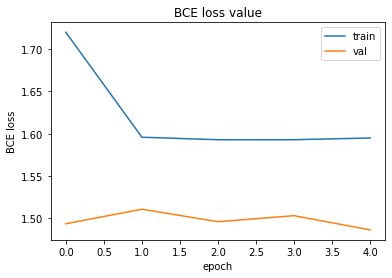

In [46]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

ну, модель не обучается... жалко(((